**전처리는 모듈을 import하여 진행**  
**전처리가 끝난 matrix 불러와 모델 학습 할것**

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import joblib
from modules import * #전처리에 필요한 함수들 
from module_preprocessing import preprocessing #인코딩하는 함수
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [2]:
#pip install joblib

In [3]:
df1=pd.read_csv("ads_1/헤드폰+%2B원고료 -내돈ANSI_45_1_edited.csv", engine='python')
df2=pd.read_csv("reviews_0/헤드폰+%2B구매 -원고료ANSI_469_0_edited.csv", engine='python') 

In [4]:
# 데이터프레임 하나로 합치기
df_a=append(df1, df2, "new")

appending...
df1.shape :  (427, 8)
df2.shape :  (82, 8)


# preprocessing

In [5]:
new_matrix=preprocessing(df_a, "headphone")

cleaning...
tokenizing...
erasing stopwords...
encoding...
number of encoded features : 9762
dimension of feature_matrix : (509, 9762)
tfid/headphone.pkl is saved
adding columns...
4 columns added successfully : (509, 9766)
matrix/headphone is saved


# 5. 모델링

### matrix, tfid 불러오기

In [21]:
new_matrix=np.load("matrix/headphone.npy")
tfid=joblib.load("tfid/headphone.pkl")

### 데이터셋 쪼개기

In [7]:
# 1) 종속변수와 독립변수로 나누기 
train_data=new_matrix
target_data=df_a.isad

## 2) 각각을 8:2로 나누기 (train과 test 셋)
x_train,x_test,y_train,y_test=train_test_split(train_data, target_data, test_size=0.2)

## 3) train을 다시 8:2로 나누기 (train과 valid)
x_train,x_valid,y_train,y_valid=train_test_split(x_train,y_train, test_size=0.2)

### 랜덤포레스트

In [8]:
forest= RandomForestClassifier(n_estimators=100, oob_score=True) 
forest.fit(x_train, y_train)

print(" training set : ", forest.score(x_train, y_train))
print(" validation set : ", forest.score(x_valid, y_valid))
print(" test set : ", forest.score(x_test, y_test))

 training set :  1.0
 validation set :  0.8292682926829268
 test set :  0.8431372549019608


**분류에 중요한 특성은?**

In [9]:
importances=forest.feature_importances_ #각 특성들의 중요도
indices=np.argsort(importances)[::-1] #내림차순으로 데이터의 위치를 반환
feature_names=tfid.get_feature_names()+['img', 'sticker', 'video', 'tags'] #특성 이름 리스트
names=[feature_names[i]for i in indices]
feature_list=pd.DataFrame({"feature" : names, "importance" : importances[indices]})
feature_list.head(20)

,feature,importance
0,img,0.007846
1,보스,0.007558
2,거지,0.006245
3,ifi,0.005977
4,넘어가,0.005223
5,가볍,0.004836
6,수명,0.003944
7,어댑터,0.003534
8,접히,0.003518
9,power,0.003478


In [10]:
len(feature_names)

9766

In [11]:
# 특정 키워드의 중요도 확인하기 
feature_list[feature_list.feature=='구매']

,feature,importance
29,구매,0.0026


최적의 max_depth, n_estimators 찾기

**랜덤포레스트 모델 저장**

In [12]:
joblib.dump(tfid, 'tfid3.pkl')

['tfid3.pkl']

### 나이브 베이즈 모델
https://wikidocs.net/34389  
이산 데이터를 이용하므로 다항 나이브 베이즈 분류기를 사용한다.  
연속적인 특성만 있을 때에는 나이브 베이즈 분류기를 사용하는데, 이게 성능이 더 좋음  

In [13]:
#모델 생성
model=GaussianNB()
model.fit(x_train, y_train) #정수화한 matrix를 넣어야 함

GaussianNB(priors=None, var_smoothing=1e-09)

In [14]:
print(" training set : ", model.score(x_train, y_train))
print(" validation set : ", model.score(x_valid, y_valid))
print(" test set : ", model.score(x_test, y_test))

 training set :  1.0
 validation set :  0.8048780487804879
 test set :  0.8333333333333334


**나이브베이즈 모델 저장**

In [15]:
joblib.dump(model, 'naive3.pkl')

['naive3.pkl']

### 딥러닝

# 6. 성능 평가
랜덤포레스트 관련 자세한 설명 : https://analysis-flood.tistory.com/103

### OOB 데이터로 랜덤포레스트 평가

In [16]:
forest.oob_score_

0.84

# 7. 모델 예측
학습에 사용하지 않은 값 넣어 예측해보기

In [17]:
# new_observation=[['이번에 받은 에어프라이어 너무 좋네요~ 내돈내산 솔직 후기! ','성별','지역','관심사']]
# classifier=joblib.load("tfid1.pkl")
# prediction=classifier.predict(new_observation)
# prediction

# 빈도 시각화

In [18]:
# 그래프 한국어 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["font.family"]="Malgun Gothic"

In [19]:
feature_list

,feature,importance
0,img,0.007846
1,보스,0.007558
2,거지,0.006245
3,ifi,0.005977
4,넘어가,0.005223
...,...,...
9761,알아차리,0.000000
9762,알파,0.000000
9763,알파고,0.000000
9764,알파벳,0.000000


([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

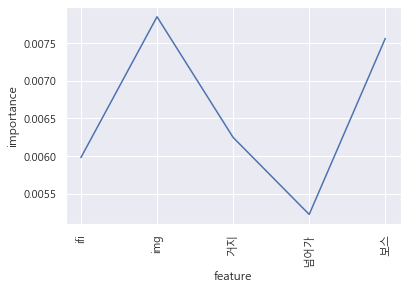

In [20]:
sns.lineplot(x=feature_list.feature, 
             y=feature_list.importance[feature_list.importance>0.005]
            )
plt.xticks(rotation=90)